# Areal data modelling

## Areal data

In spatial statistics, areal data refers to data that are aggregated or summarized within predefined geographic areas or regions, such as census tracts, zip code areas, counties, or administrative districts. Unlike point-referenced data, which represent individual locations with specific coordinates, areal data are associated with spatial units that cover an area on the map.

Examples of areal data include:

- Population counts: Total population counts within census tracts or administrative districts.
- Income levels: Median household income or per capita income within counties or zip code areas.
- Disease rates: Incidence or prevalence rates of diseases within specific regions.
- Crime rates: Number of reported crimes per capita within police precincts or neighborhoods.
- Environmental variables: Average temperature, precipitation, or air quality indices within specific geographic regions.
- Socioeconomic indicators: Education attainment levels, unemployment rates, poverty rates, etc., within administrative boundaries.

Areal data are commonly used in spatial statistics since this is often the level at which data are available, and, at the same time, modelling at areal level is useful since this is the level at which public policy decisions are typically made.

In [3]:
#!pip install geopandas

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from shapely.geometry import Polygon

import numpy as np

import networkx as nx

import jax


## Geopandas

Before we start looking at statististical models of areal data, let us get familiar with the `geopandas` package.

`geopandas` is a Python library that provides convenient, unified access to the functionalities of the `pandas` library and additional spatial data manipulation tools. It is built upon the capabilities of pandas, allowing for easy manipulation, analysis, and visualization of geospatial data.

Here's a brief tutorial to get you started with GeoPandas:

1. Installation

    First, you need to install GeoPandas along with its dependencies. You can install GeoPandas using pip, a Python package manager, by executing the following command in your terminal or command prompt:

    `!pip install geopandas`

2. Importing

    Once GeoPandas is installed, you can import it in your Python script or Jupyter Notebook:

    `import geopandas as gpd`

3. Reading Spatial Data

    GeoPandas can read various spatial data formats such as shapefiles, GeoJSON, and GeoPackage. You can read spatial data using the read_file() function:

In [ ]:
# Reading a shapefile
#gdf = gpd.read_file('data/zaf.geojson')
gdf = gpd.read_file('data/wards_UK.geojson')


4. Exploring Data

    GeoPandas extends the capabilities of pandas DataFrames to work with spatial data. You can use familiar pandas methods to explore and manipulate GeoDataFrames:

In [ ]:
gdf.head()

In [ ]:
# Displaying the first few rows of the GeoDataFrame
print(gdf.head())

# Summary statistics
print(gdf.describe())

# Checking column names
print(gdf.columns)

# Plotting the GeoDataFrame
gdf.plot()


5. Spatial Operations

    GeoPandas allows you to perform spatial operations such as overlay, buffer, and spatial joins:

In [ ]:
# Performing a spatial join
result = gpd.sjoin(gdf1, gdf2, how='inner', op='intersects')

# Buffering geometries
buffered = gdf.buffer(distance=1000)  # Buffer by 1000 units

# Overlaying geometries
intersection = gpd.overlay(gdf1, gdf2, how='intersection')


: 

6. Plotting

    GeoPandas provides easy-to-use plotting functions to visualize spatial data:

In [ ]:
# Plotting a GeoDataFrame
gdf.plot()

# Customizing the plot
ax = gdf.plot(color='blue', edgecolor='black')


7. Saving Data

    You can save GeoDataFrames to various spatial data formats using the to_file() method:

In [ ]:
# Saving GeoDataFrame to a shapefile
gdf.to_file('path/to/output.shp')


In [4]:
# Specify the path to your GeoJSON file
geojson_path = 'data/zaf.geojson'

# Read the GeoJSON file using GeoPandas
gdf = gpd.read_file(geojson_path)

In [ ]:
gfd

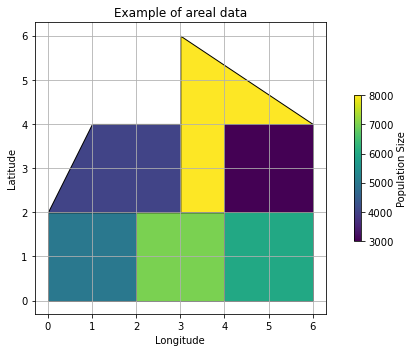

In [15]:
# Create a GeoDataFrame with administrative boundaries (made-up data for illustration)
data = {'geometry': [Polygon([(0, 0), (0, 2), (2, 2), (2, 0)]),  # Polygon 1
                     Polygon([(2, 0), (2, 2), (4, 2), (4, 0)]),  # Polygon 2
                     Polygon([(0, 2), (1, 4), (3, 4), (3, 2)]),  # Polygon 3
                     Polygon([(3, 2), (3, 6), (6, 4), (5, 2)]),  # Polygon 4
                     Polygon([(4, 0), (4, 2), (6, 2), (6, 0)]),  # Polygon 5
                     Polygon([(4, 2), (4, 4), (6, 4), (6, 2)])],  # Polygon 6
        'Name': ['Admin District 1', 'Admin District 2', 'Admin District 3',
                 'Admin District 4', 'Admin District 5', 'Admin District 6'],  # Names of admin districts
        'Population': [5000, 7000, 4000, 8000, 6000, 3000]}  # Population counts for each admin district

gdf_admin = gpd.GeoDataFrame(data)

# Plot the administrative boundaries with population size represented by color
fig, ax = plt.subplots(figsize=(8, 5))

# Define colormap
cmap = plt.cm.viridis  # Change the colormap here
norm = Normalize(vmin=gdf_admin['Population'].min(), vmax=gdf_admin['Population'].max())
sm = ScalarMappable(norm=norm, cmap=cmap)

# Plot each administrative boundary with color based on population size
for idx, row in gdf_admin.iterrows():
    color = sm.to_rgba(row['Population'])
    gdf_admin.iloc[[idx]].plot(ax=ax, color=color, edgecolor='black')

# Add colorbar with a shorter length
cbar = plt.colorbar(sm, shrink=0.5)  # Adjust the shrink parameter to change the length of the color bar
cbar.set_label('Population Size')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Example of areal data')
plt.grid(True)
plt.tight_layout()
plt.show()


## Adjancency structure

Most models of areal data rely on the concept of adjacency matrix, i.e. a matrix $A = (a_{ij})$ with entries

$$
a_{ij} = \begin{cases}
			1, & \text{if areas } B_i \text{ and } B_j \text{ are neighbours},\\
            0, & \text{otherwise}.
		 \end{cases}
$$

The adjacency matrix must be symmetric: 

$$
A = \begin{pmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{12} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{1n} & a_{2n} & \cdots & a_{nn}
\end{pmatrix}
$$



Let us compute adjacency matrix for this data.

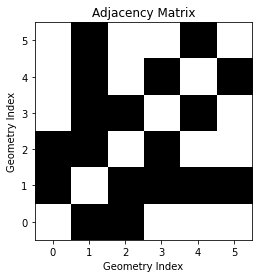

In [28]:
def compute_adjacency_matrix(gdf):
    num_geometries = len(gdf)
    adjacency_matrix = np.zeros((num_geometries, num_geometries), dtype=int)
    
    for idx1, geometry1 in enumerate(gdf.geometry):
        for idx2, geometry2 in enumerate(gdf.geometry):
            if idx1 != idx2:
                if geometry1.touches(geometry2):  # Check if geometries share a common boundary
                    adjacency_matrix[idx1, idx2] = 1
    
    return adjacency_matrix

def visualize_adjacency_matrix(matrix):
    plt.figure(figsize=(6, 4))
    plt.imshow(matrix, cmap='binary', origin='lower')
    plt.title('Adjacency Matrix')
    plt.xlabel('Geometry Index')
    plt.ylabel('Geometry Index')
    plt.grid(False)
    plt.show()

# Compute adjacency matrix
adjacency_matrix = compute_adjacency_matrix(gdf_admin)

# Visualize the adjacency matrix
visualize_adjacency_matrix(adjacency_matrix)

To understand adjacency, we can think about areal data as graphs with binary edges. Here each area represents a vertex in a graph, and an edge exists between vertices $i$ and $j$ if areas $B_i$ and $B_j$ share a border.

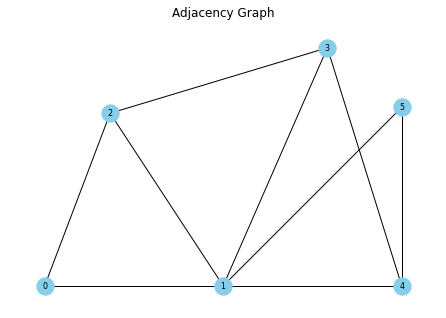

In [29]:
# Create a graph
nx_graph = nx.Graph()

# Add nodes with their coordinates and area names
for idx, geometry in enumerate(gdf_admin.geometry):
    centroid = geometry.centroid
    #area_name = gdf.loc[idx, 'area_name']
    #nx_graph.add_node(idx, pos=(centroid.x, centroid.y), label=area_name)
    nx_graph.add_node(idx, pos=(centroid.x, centroid.y))

# Add edges based on adjacency
for i, j in zip(*np.where(adjacency_matrix == 1)):
    nx_graph.add_edge(i, j)

# Visualize the graph with nodes aligned with actual locations and labeled with area names
pos = nx.get_node_attributes(nx_graph, 'pos')

nx.draw(nx_graph, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=8, font_color="black")
plt.title('Adjacency Graph')
plt.show()

## Models of areal data

In models for areal data, the geographic units are denoted by $B_i$, and the data are typically sums or averages of variables over these blocks. To introduce spatial association, we define a neighborhood structure based on the arrangement of the blocks in the map. Once the neighborhood structure is defined, one can construct models models resembling autoregressive time series models, such as the intrinsic conditionally autoregressive model (ICAR, also called Besag) and conditionally autoregressive model (CAR).

### The Besag, or ICAR, model

```{margins}
Some literature deciphers 'I' in 'ICAR' as 'intrinsic', and some other as 'improper'.
```
The Besag, or ICAR (Intrinsic Conditional Autoregressive) model is used to account for spatial dependencies or autocorrelation in the data, where observations in close proximity tend to be more similar than those farther apart. The ICAR model is a type of conditional autoregressive model that assumes that the value of a location in a spatial dataset depends on the values of its neighboring locations.

Here are the key components of the ICAR model:

- Neighborhood Structure: The ICAR model requires a predefined neighborhood structure. This structure specifies which locations are considered neighbors of each other. Common choices include defining neighbors based on contiguity, distance thresholds, or some other criteria.

- Conditional Autoregressive Structure: In the ICAR model, each location's value is assumed to be conditionally dependent on the values of its neighbors. This conditional dependency is often modeled as a weighted sum of the neighboring values, where the weights are determined by the neighborhood structure. The weights are typically constrained such that they sum to zero, ensuring stationarity of the model.

- Intrinsic Condition: The "intrinsic" part of the ICAR model refers to the fact that the sum of the weights for each location is constrained to be zero. This constraint helps ensure identifiability of the model parameters.

The ICAR model is useful in various spatial applications, such as spatial interpolation, spatial smoothing, and spatial prediction. It is commonly employed in Bayesian spatial modeling, where prior distributions are assigned to the model parameters, and the posterior distribution is obtained through Bayesian inference methods like Markov Chain Monte Carlo (MCMC) sampling.


The Besag model, also called improper conditionally autoregressive model (ICAR) computes the conditional mean of the random effect $f_i$ as an average of its neighbours $\{f_j \}_{j\sim i}$ and its precision is proportional to the number of neighbours. It describes the vector of spatially varying random effects $f = (f_1, ..., f_n)^T$ using the prior

$$
f \sim \mathcal{N}(0, Q^-).
$$

Here $Q^-$ denotes the generalised inverse of matrix $Q$, which, in turn, is computed as 

$$
Q = \tau R, \\
R = D - A.
$$

Here $D$ is a diagnoal matrix. It's $i$-th element equals the total number of neighbours of area $i$. Hence, $D$ can be computed from $A$:

$$
D = \begin{pmatrix}
\sum_{j=1}^n  a_{1j} & 0 & \cdots & 0 \\
0 & \sum_{j=1}^n a_{2j} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \sum_{j=1}^n a_{nj}
\end{pmatrix}.
$$

Note that  the structure matrix here can be viewed as graph Laplacian.

$R$ is a rank-defficient matrix. It is recommended, for example, to place an adidtional constraint, such sum-to-zero constraint on each non-singleton connected component:

$$
\sum_i f_i = 0.
$$



### Conditional Autoregressive Models (CAR)

Conditional Autoregressive Models (CAR): same as ICAR, the CAR model assumes that the value of a variable in one area depends on the values of neighboring areas, with weights specified by a spatial adjacency matrix. However, it introcues an additional parameter $\alpha$, allowing to estimate the amount of spatial correlation.

The psatial random effect now is modelled as

$$f \sim \mathcal{N}(0, Q^{-1}) $$

with 

$$
Q = \tau R, \\
R = D - \alpha A, \\
0 \le \alpha < 1.
$$

If $\alpha=0$, the model consist only of i.i.d. random effects, and if $\alpha$ is close to 1, the model approaches ICAR.
 
### The Besag-Yorg-Mollié model

The Besag, York, and Mollié (BYM) decomposes the spatial random effect $f$ into the sum of an i.i.d. component $v$ and spatiallly structured component $w$. Each of these two components has its own precision parameter:

$$
f \sim \mathcal{N}(0, \tau_v^{-1}I + \tau_w^{-1}R^-).
$$

This model provides more flexibility than the CAR formulation. 



##

## Examples

take data from here: https://hughst.github.io/week-7/